In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
class MergeLayerC(nn.Module):
    
    def __init__(self):
        super(MergeLayerC, self).__init__()
        self.conv0 = nn.Conv2d(8, 4, 15, padding = 7, bias=False)
        
        self.conv1 = nn.Conv2d(4, 4, 3, stride = 2, bias=False) #padding left to F.pad
        self.conv2 = nn.Conv2d(4, 4, 3, stride = 2, bias=False)
        self.conv3 = nn.Conv2d(4, 4, 3, stride = 2, bias=False)
        self.upconv1 = nn.ConvTranspose2d(4, 4, 2, stride = 2, bias=False) 
        self.upconv2 = nn.ConvTranspose2d(4, 4, 2, stride = 2, bias=False) 
        self.upconv3 = nn.ConvTranspose2d(4, 4, 2, stride = 2, bias=False) 
        
    def gauss_pyramid(self, x):
        G = x.clone()
        gp = [G]
        x = self.conv1(F.pad(x, (0, 1, 0, 1), mode = 'reflect'))
        gp.append(x)
        x = self.conv2(F.pad(x, (0, 1, 0, 1), mode = 'reflect'))
        gp.append(x)
        x = self.conv3(F.pad(x, (0, 1, 0, 1), mode = 'reflect'))
        gp.append(x)
        
        return gp
    
    def lap_pyramid(self, x):
        gp = self.gauss_pyramid(x)
        lp = [gp[-1]]
        GE = self.upconv1(gp[-1])
        L = gp[-2] - GE
        lp.append(L)
        GE = self.upconv2(gp[-2])
        L = gp[-3] - GE
        lp.append(L)
        GE = self.upconv3(gp[-3])
        L = gp[-4] - GE
        lp.append(L)
        return lp
        
    
    def forward(self, x):
        ## x size: (batch_size, 4(rggb)*2, H//2, W//2)
        mm = F.relu(torch.cat([self.conv0(x), -self.conv0(x)], dim = 1))
        mm = torch.sum(mm, dim = 1, keepdim=True)
        mask = torch.sigmoid(mm.repeat(1, 4, 1, 1) - 700.0)
        ref = x[:, :4]
        alt = x[:, 4:]
        lp_ref = self.lap_pyramid(ref)
        lp_alt = self.lap_pyramid(alt)
        gp_mask = [mask, F.max_pool2d(mask, 2), F.max_pool2d(F.max_pool2d(mask, 2), 2), 
                   F.max_pool2d(F.max_pool2d(F.max_pool2d(mask, 2), 2), 2)]#self.gauss_pyramid(mask)
        
        LS = []
        for la,lb,mask in zip(lp_ref,lp_alt, gp_mask[::-1]):
            ls = la * mask + lb * (1.0 - mask)
            LS.append(ls)
        
        ls_ = LS[0]
        ls_ = self.upconv1(ls_)
        ls_ = ls_ + LS[1]
        ls_ = self.upconv2(ls_)
        ls_ = ls_ + LS[2]
        ls_ = self.upconv3(ls_)
        ls_ = ls_ + LS[3]
        
        return ls_

In [3]:
model = MergeLayerC()
model.load_state_dict(torch.load('model.pth'))
model = model.cuda()
model.eval()

MergeLayerC(
  (conv0): Conv2d(8, 4, kernel_size=(15, 15), stride=(1, 1), padding=(7, 7), bias=False)
  (conv1): Conv2d(4, 4, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (conv2): Conv2d(4, 4, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (conv3): Conv2d(4, 4, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (upconv1): ConvTranspose2d(4, 4, kernel_size=(2, 2), stride=(2, 2), bias=False)
  (upconv2): ConvTranspose2d(4, 4, kernel_size=(2, 2), stride=(2, 2), bias=False)
  (upconv3): ConvTranspose2d(4, 4, kernel_size=(2, 2), stride=(2, 2), bias=False)
)

In [4]:
import sys
sys.path.append("../")
from utils import *
sys.path.append("../Google_HDRplus/")
from merge_utils import *
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
bk_lvl = 50
print("black level of the sensor: ", bk_lvl)

black level of the sensor:  50


In [6]:
rIm=read_raw("../static_videos/lowlight3_frame16_bunny_3.raw", frame =16)
rIm = rIm[:, :2048, :3584]
ref_idx = 0

In [7]:
import time
start = time.time()
ref = rIm[ref_idx]
ref_stack = raw_to_stack(ref)
ref_t = torch.from_numpy(ref_stack.copy().transpose(2, 0, 1))
final = rIm[ref_idx].copy().astype(np.float64)
for idx in range(1, 16):
    print("merge {}th raw frame...".format(idx))
    alt = np.load('../flow_test/warped_npys_lowlight3_bunny3/warped_{}.npy'.format(idx))
    alt_stack = raw_to_stack(alt)
    alt_t = torch.from_numpy(alt_stack.copy().transpose(2, 0, 1))
    inputs = torch.cat([ref_t, alt_t], dim = 0).unsqueeze(0)
    outputs = model(inputs.float().cuda())
    img = outputs[0].detach().cpu().numpy().transpose(1, 2, 0)
    img = stack_to_raw(img)
    merged_frame = img.astype(ref.dtype)
    final += merged_frame
print("elapsed time: {:.2f}".format(time.time() - start))

merge 1th raw frame...
merge 2th raw frame...
merge 3th raw frame...
merge 4th raw frame...
merge 5th raw frame...
merge 6th raw frame...
merge 7th raw frame...
merge 8th raw frame...
merge 9th raw frame...
merge 10th raw frame...
merge 11th raw frame...
merge 12th raw frame...
merge 13th raw frame...
merge 14th raw frame...
merge 15th raw frame...
elapsed time: 9.84


In [8]:
rIm_merge = final - bk_lvl* rIm.shape[0]
rIm_merge = rIm_merge.astype(np.int16)
rIm_merge = np.clip(rIm_merge, 0, 1023)
print_stat("rIm_merge", rIm_merge)
bit_length = np.log2(rIm_merge.max())
print("bit_length", bit_length)

rIm_merge  shape:  (2048, 3584) dtype: int16
rIm_merge stat: max: 410, min: 0, mean: 104.25444167000907, std: 55.75907577279653
bit_length 8.679481


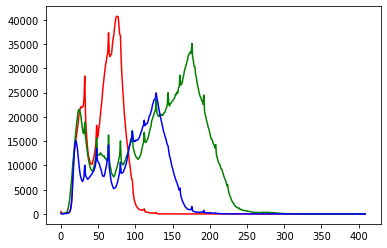

In [9]:
plot_histogram(rIm_merge, bit_length)

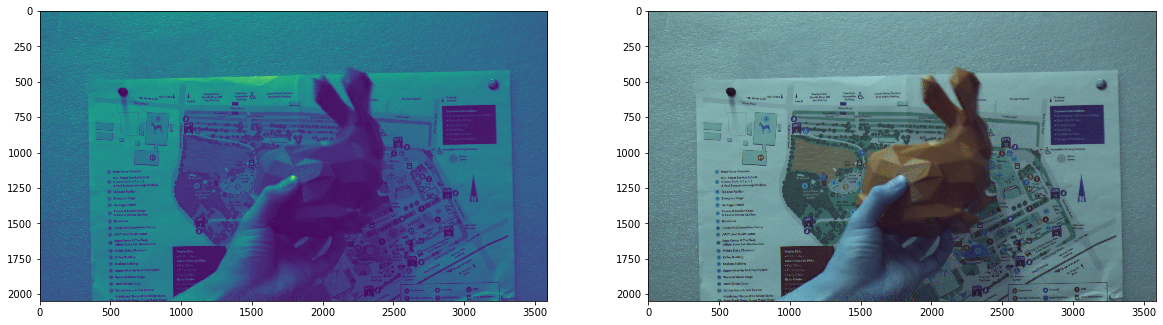

In [10]:
rgbIm_merge = demosaic(rIm_merge)
rgbIm_adj_merge = adjustColor(rgbIm_merge,rc = 1, bc = 1, gc = 0.7, gain=1.3, gamma = 1.25, contrast=1.5)
fig, ax = plt.subplots(1, 2, figsize=(20, 16))
ax[0].imshow(rIm_merge)
ax[1].imshow(rgbIm_adj_merge)
plt.show()

rIm_single  shape:  (2048, 3584) dtype: int16
rIm_single stat: max: 27, min: 0, mean: 6.548732621329171, std: 3.5766085926180717
bit_length 4.7548876


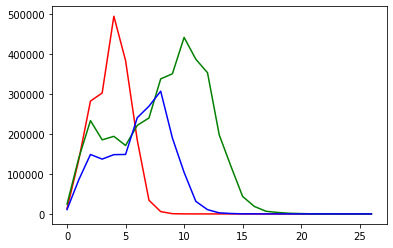

In [11]:
rIm_single = rIm[ref_idx] - bk_lvl
rIm_single = np.clip(rIm_single, 0, 1023)
print_stat("rIm_single",rIm_single)
bit_length = np.log2(rIm_single.max())
print("bit_length", bit_length)
plot_histogram(rIm_single, bit_length)

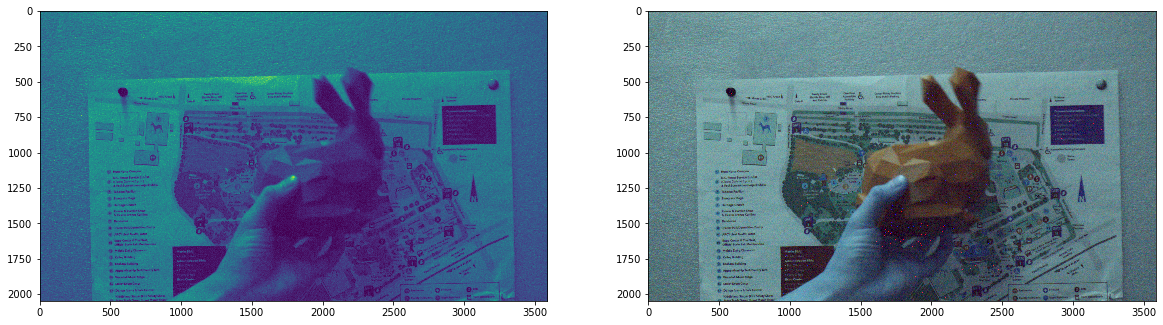

In [12]:
rgbIm_single = demosaic(rIm_single)
rgbIm_adj_single = adjustColor(rgbIm_single,rc = 1, bc = 1, gc = 0.7, gain=1.3, gamma = 1.25, contrast=1.5)
fig, ax = plt.subplots(1, 2, figsize=(20, 16))
ax[0].imshow(rIm_single)
ax[1].imshow(rgbIm_adj_single)
plt.show()

rIm_sum  shape:  (2048, 3584) dtype: int64
rIm_sum stat: max: 425, min: 2, mean: 105.40667057037354, std: 54.342939102707916
bit_length 8.731319031025064


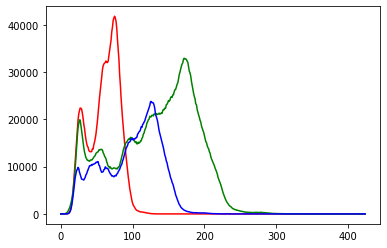

In [13]:
rIm_sum = rIm.sum(axis = 0) - bk_lvl* rIm.shape[0]
print_stat("rIm_sum", rIm_sum)
bit_length = np.log2(rIm_sum.max())
print("bit_length", bit_length)
plot_histogram(rIm_sum, bit_length)

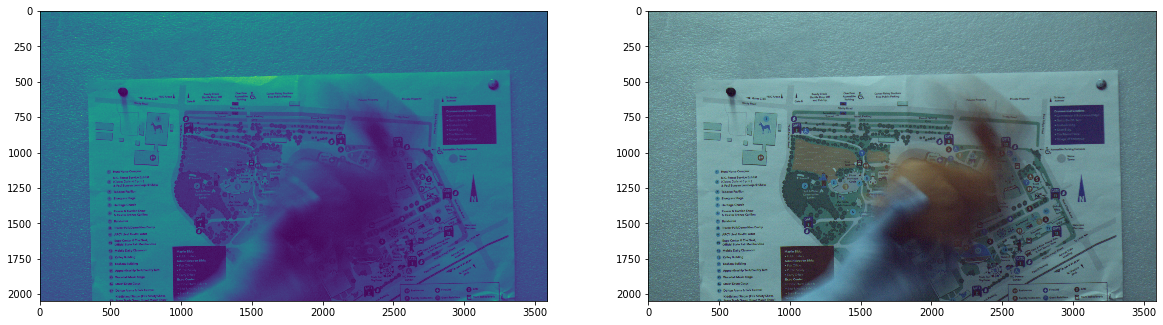

In [14]:
rIm_sum = np.clip(rIm_sum, 0, 1023)
rgbIm = demosaic(rIm_sum)
rgbIm_adj = adjustColor(rgbIm,rc = 1, bc = 1, gc = 0.7, gain=1.3, gamma = 1.25, contrast=1.5)
fig, ax = plt.subplots(1, 2, figsize=(20, 16))
ax[0].imshow(rIm_sum)
ax[1].imshow(rgbIm_adj)
plt.show()

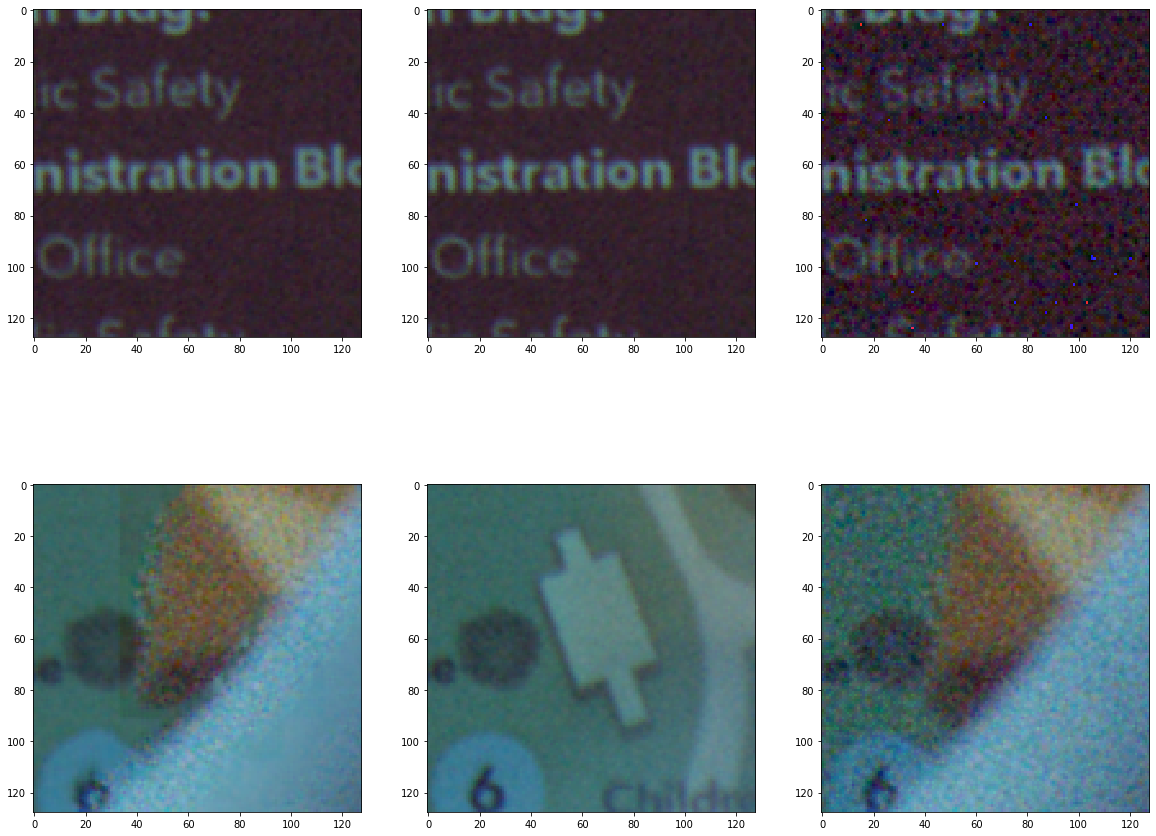

In [15]:
fig, ax = plt.subplots(2, 3, figsize=(20, 16))
ax[0][0].imshow(rgbIm_adj_merge[1700:1828, 1020:1148])
ax[0][1].imshow(rgbIm_adj[1700:1828, 1020:1148])
ax[0][2].imshow(rgbIm_adj_single[1700:1828, 1020:1148])
ax[1][0].imshow(rgbIm_adj_merge[1300:1300+128, 1550-128:1550])
ax[1][1].imshow(rgbIm_adj[1300:1300+128, 1550-128:1550])
ax[1][2].imshow(rgbIm_adj_single[1300:1300+128, 1550-128:1550])
plt.show()

In [16]:
import cv2
cv2.imwrite("rgbIm_adj_merge_ref{}.png".format(ref_idx), rgbIm_adj_merge[..., ::-1])
cv2.imwrite("rgbIm_adj_ref{}.png".format(ref_idx), rgbIm_adj[..., ::-1])
cv2.imwrite("rgbIm_adj_single_ref{}.png".format(ref_idx), rgbIm_adj_single[..., ::-1])

True

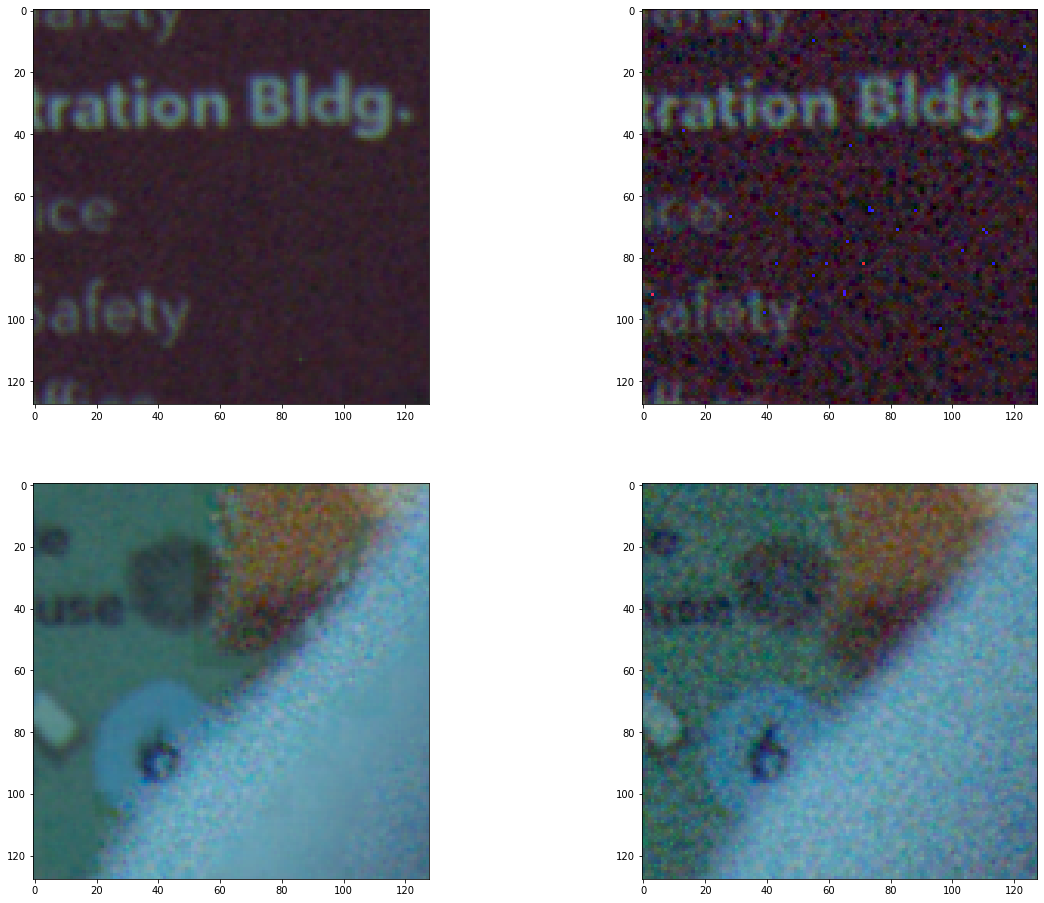

In [17]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
ref_idx = 0
rgbIm_adj = cv2.imread("rgbIm_adj_ref{}.png".format(ref_idx))[..., ::-1]
rgbIm_adj_single = cv2.imread("rgbIm_adj_single_ref{}.png".format(ref_idx))[..., ::-1]
rgbIm_adj_merge = cv2.imread("rgbIm_adj_merge_ref{}.png".format(ref_idx))[..., ::-1]

fig, ax = plt.subplots(2, 2, figsize=(20, 16))
ax[0][0].imshow(rgbIm_adj_merge[1732:1828+32, 1020+32:1148+32])
ax[0][1].imshow(rgbIm_adj_single[1732:1828+32, 1020+32:1148+32])
ax[1][0].imshow(rgbIm_adj_merge[1332:1332+128, 1532-128:1532])
ax[1][1].imshow(rgbIm_adj_single[1332:1332+128, 1532-128:1532])
plt.show()